In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Set device
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    device = torch.device("cuda")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()  # Free up unused memory

Using 2 GPUs


In [3]:

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:

class MedicinalPlantDataset(Dataset):
    def __init__(self, root_dirs, prefixes, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()
        
        for root_dir, prefix in zip(root_dirs, prefixes):
            for cls in sorted(os.listdir(root_dir)):
                class_path = os.path.join(root_dir, cls)
                if os.path.isdir(class_path):
                    class_name = f"{prefix}_{cls}"  # Differentiate class names
                    self.classes.add(class_name)
                    for img_name in os.listdir(class_path):
                        img_path = os.path.join(class_path, img_name)
                        if img_name.lower().endswith(('png', 'jpg', 'jpeg')):  # Ignore non-image files
                            self.image_paths.append(img_path)
                            self.labels.append(class_name)
        
        self.classes = sorted(list(self.classes))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.labels = [self.class_to_idx[label] for label in self.labels]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except UnidentifiedImageError:
            return self.__getitem__((idx + 1) % len(self.image_paths))  # Skip invalid images
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
# Define dataset paths
dataset_root = r"/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets"
leaf_dataset_path = os.path.join(dataset_root, r"/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset")
plant_dataset_path = os.path.join(dataset_root, r"/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset")

In [6]:
# Load combined dataset with differentiated class names
dataset = MedicinalPlantDataset([leaf_dataset_path, plant_dataset_path], prefixes=["Leaf", "Plant"], transform=data_transforms['train'])
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Print the loaded classes
print("Classes loaded in the dataset:")
for class_name in idx_to_class.values():
    print(class_name)

Classes loaded in the dataset:
Leaf_Aloevera
Leaf_Amla
Leaf_Amruthaballi
Leaf_Arali
Leaf_Astma_weed
Leaf_Badipala
Leaf_Balloon_Vine
Leaf_Bamboo
Leaf_Beans
Leaf_Betel
Leaf_Bhrami
Leaf_Bringaraja
Leaf_Caricature
Leaf_Castor
Leaf_Catharanthus
Leaf_Chakte
Leaf_Chilly
Leaf_Citron lime (herelikai)
Leaf_Coffee
Leaf_Common rue(naagdalli)
Leaf_Coriender
Leaf_Curry
Leaf_Doddpathre
Leaf_Drumstick
Leaf_Ekka
Leaf_Eucalyptus
Leaf_Ganigale
Leaf_Ganike
Leaf_Gasagase
Leaf_Ginger
Leaf_Globe Amarnath
Leaf_Guava
Leaf_Henna
Leaf_Hibiscus
Leaf_Honge
Leaf_Insulin
Leaf_Jackfruit
Leaf_Jasmine
Leaf_Kambajala
Leaf_Kasambruga
Leaf_Kohlrabi
Leaf_Lantana
Leaf_Lemon
Leaf_Lemongrass
Leaf_Malabar_Nut
Leaf_Malabar_Spinach
Leaf_Mango
Leaf_Marigold
Leaf_Mint
Leaf_Neem
Leaf_Nelavembu
Leaf_Nerale
Leaf_Nooni
Leaf_Onion
Leaf_Padri
Leaf_Palak(Spinach)
Leaf_Papaya
Leaf_Parijatha
Leaf_Pea
Leaf_Pepper
Leaf_Pomoegranate
Leaf_Pumpkin
Leaf_Raddish
Leaf_Rose
Leaf_Sampige
Leaf_Sapota
Leaf_Seethaashoka
Leaf_Seethapala
Leaf_Spinach1
Le

In [7]:


# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [8]:


# Apply different transforms to train and validation sets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

In [9]:

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [10]:


# Load Pretrained Model
model = models.efficientnet_v2_l(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(dataset.classes))
# Enable Multi-GPU Support
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:02<00:00, 178MB/s]


In [11]:
# Enable mixed precision training to reduce memory usage
scaler = torch.amp.GradScaler(device='cuda')

In [12]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [13]:

# Training Loop with Mixed Precision
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    best_acc = 0.0
    train_accuracies = []  # To store training accuracy for each epoch
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.autocast('cuda'):  # Mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = 100 * correct / total
        train_accuracies.append(train_acc)
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        val_accuracies.append(val_acc)
        print(f'Epoch {epoch+1}/{epochs}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        scheduler.step()
        torch.cuda.empty_cache()  # Free GPU memory
    return train_accuracies, val_accuracies
# Call the train_model function with 15 epochs
train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15)

Epoch 1/15: Train Acc: 52.64%, Val Acc: 91.28%
Epoch 2/15: Train Acc: 93.24%, Val Acc: 97.35%
Epoch 3/15: Train Acc: 98.17%, Val Acc: 97.98%
Epoch 4/15: Train Acc: 99.22%, Val Acc: 98.33%
Epoch 5/15: Train Acc: 99.35%, Val Acc: 98.79%
Epoch 6/15: Train Acc: 99.66%, Val Acc: 98.64%
Epoch 7/15: Train Acc: 99.74%, Val Acc: 98.44%
Epoch 8/15: Train Acc: 99.77%, Val Acc: 98.72%
Epoch 9/15: Train Acc: 99.81%, Val Acc: 98.37%
Epoch 10/15: Train Acc: 99.95%, Val Acc: 98.64%
Epoch 11/15: Train Acc: 99.88%, Val Acc: 98.79%
Epoch 12/15: Train Acc: 99.83%, Val Acc: 98.68%
Epoch 13/15: Train Acc: 99.86%, Val Acc: 98.68%
Epoch 14/15: Train Acc: 99.83%, Val Acc: 98.44%
Epoch 15/15: Train Acc: 99.74%, Val Acc: 98.64%


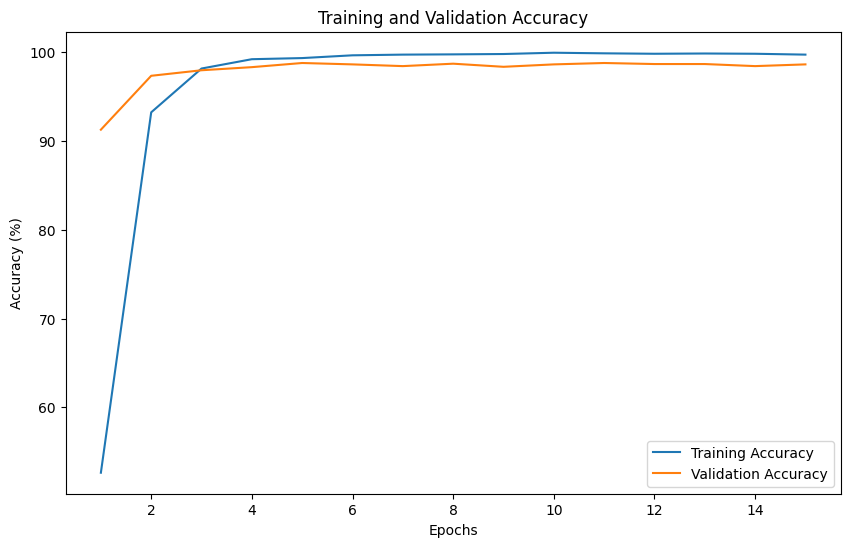

In [14]:
# Plot accuracy graphs
def plot_accuracy(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Plot accuracy after training
plot_accuracy(train_accuracies, val_accuracies)

In [15]:
import torch
from sklearn.metrics import accuracy_score

def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    criterion = torch.nn.CrossEntropyLoss()  # Use the same loss function as training
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_accuracy = (correct / total) * 100
    test_loss = total_loss / len(test_loader)
    
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

# Call evaluation function
evaluate_model(model, val_loader)  # Use validation loader as test set

Test Accuracy: 98.64%
Test Loss: 0.0704


In [16]:
# Save the trained model
def save_model(model, path="medicinal_classifier2.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved as {path}")

save_model(model, "medicinal_classifier2.pth")

Model saved as medicinal_classifier2.pth


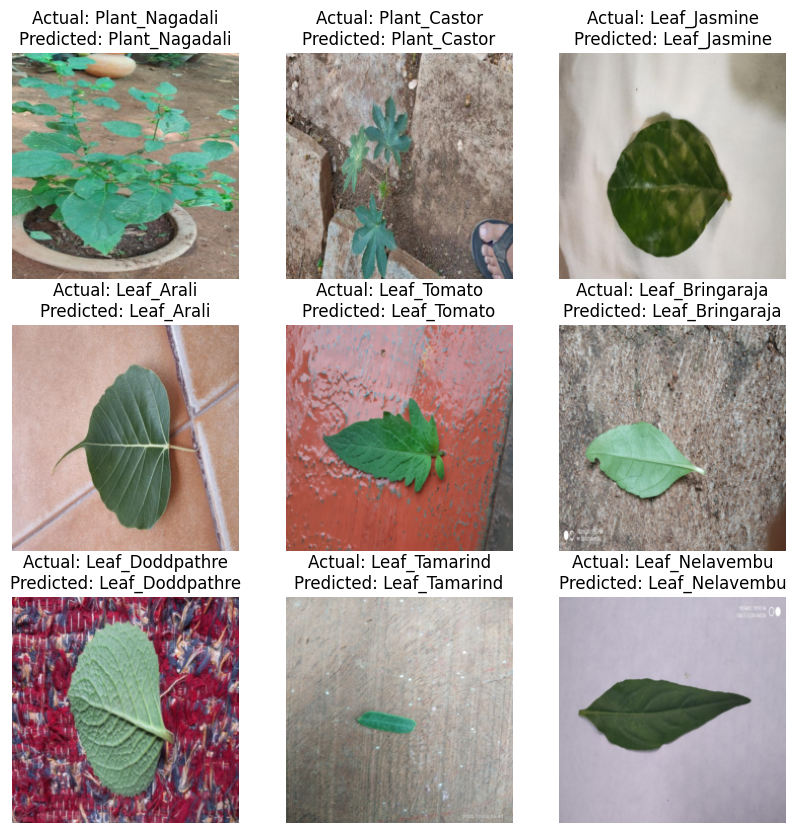

In [17]:
# Get a batch of test images and labels
test_images, test_labels = next(iter(val_loader))
test_images, test_labels = test_images.to(device), test_labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(test_images)
    _, preds = torch.max(outputs, 1)

# Get class names from dataset
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Display some predictions
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = test_images[i].cpu().permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)

    actual_label = idx_to_class[test_labels[i].item()]
    predicted_label = idx_to_class[preds[i].item()]

    ax.imshow(img)
    ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    ax.axis('off')

plt.show()

<ipython-input-18-ab8eb0a68771>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("medicinal_classifier2.pth", map_location=device)


Predicted Class: Plant_Tulasi (74.94%)


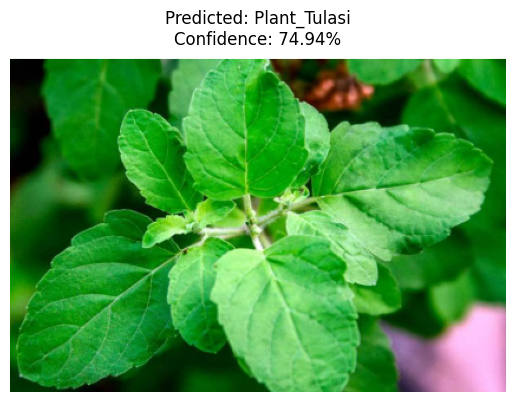

In [18]:
from PIL import Image
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load class labels (Ensure 'dataset' is properly initialized)
try:
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
except NameError:
    raise ValueError("Dataset class mapping 'dataset.class_to_idx' is not defined. Ensure dataset is properly initialized.")

# Define transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Recreate the same model architecture
model = models.efficientnet_v2_l(weights=None)  # Avoid warnings
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(idx_to_class))  # Adjust output layer

# Load trained model
try:
    state_dict = torch.load("medicinal_classifier2.pth", map_location=device)
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}  # Remove 'module.' prefix if needed
    model.load_state_dict(new_state_dict)
except Exception as e:
    raise RuntimeError(f"Error loading model: {e}")

model.to(device)
model.eval()

# Function to predict a custom image
def predict_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        raise ValueError(f"Error opening image: {e}")
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, pred = torch.max(probs, 1)
    
    predicted_class = idx_to_class[pred.item()]
    confidence_score = confidence.item() * 100  # Convert to percentage
    
    print(f"Predicted Class: {predicted_class} ({confidence_score:.2f}%)")
    
    # Show image with prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence_score:.2f}%")
    plt.axis('off')
    plt.show()

# 🔹 Test with your own image
image_path = r"/kaggle/input/images-set/Screenshot 2025-02-27 212243.png"  # Change this to your test image path
predict_image(image_path)